In [87]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, 
                                     GlobalAveragePooling2D, Multiply, Add, Concatenate, Reshape, Layer, 
                                     DepthwiseConv2D, UpSampling2D, GlobalMaxPooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2, l2




Model 1

In [88]:
class ChannelAttentionLayer(Layer):
    def __init__(self, channels, ratio=16, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
        self.shared_layers = [
            Dense(max(4, channels // ratio), activation=tf.keras.layers.LeakyReLU(alpha=0.01), use_bias=False),
            Dense(channels, activation='sigmoid', use_bias=False),
            Reshape((1, 1, channels))
        ]

    def build(self, input_shape):
        self.se = Sequential(self.shared_layers)

    def call(self, inputs, **kwargs):
        x = GlobalAveragePooling2D()(inputs)
        x = self.se(x)
        return Multiply()([inputs, x])
    
    def get_config(self):
        config = super(ChannelAttentionLayer, self).get_config()
        config.update({
            'channels': self.channels,
            'ratio': self.ratio
        })
        return config

def conv_block_with_residual(x, filters, kernel_size):
    x_main = Conv2D(filters, kernel_size, padding='same')(x)
    x_main = ChannelAttentionLayer(filters)(x_main)

    x_residual = Conv2D(filters, (1, 1), padding='same')(x)

    x_main = tf.keras.layers.LeakyReLU(alpha=0.01)(x_main)
    x_residual = tf.keras.layers.LeakyReLU(alpha=0.01)(x_residual)

    x = Add()([x_main, x_residual])
    return x

def ResidualAttentionDropoutNet(input_shape, num_classes, dropout_rate):
    inputs = Input(shape=input_shape)
    x = conv_block_with_residual(inputs, 16, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = conv_block_with_residual(x, 32, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    return Model(inputs=inputs, outputs=x), x
    # x = Dense(64)(x)
    # x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    # x = Dropout(dropout_rate)(x)
    # outputs = Dense(num_classes, activation='sigmoid')(x)
    # model = Model(inputs=inputs, outputs=outputs)
    # return model


model = ResidualAttentionDropoutNet(
    input_shape=(128, 128, 3), 
    num_classes=1,  
    dropout_rate=0.05
)


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# model.summary()

Model 2

In [89]:
class ChannelAttentionLayer(Layer):
    def __init__(self, channels, ratio=16, **kwargs):
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
     
        self.shared_layers = [
            Dense(channels // ratio, activation='relu', use_bias=False),
            Dense(channels, activation='sigmoid', use_bias=False),
            Reshape((1, 1, channels))
        ]

    def build(self, input_shape):
        self.se = Sequential(self.shared_layers)

    def call(self, inputs, **kwargs):
        x_avg = GlobalAveragePooling2D()(inputs)
        x_max = GlobalMaxPooling2D()(inputs)
        x = Concatenate()([x_avg, x_max])
        x = self.se(x)
        return Multiply()([inputs, x])

    def get_config(self):
        config = super(ChannelAttentionLayer, self).get_config()
        config.update({
            'channels': self.channels,
            'ratio': self.ratio
        })
        return config


def conv_block_with_residual(x, filters, kernel_size):
    x_main = Conv2D(filters, kernel_size, padding='same')(x)
    x_main = BatchNormalization()(x_main)
    x_main = ChannelAttentionLayer(filters)(x_main)

    x_residual = Conv2D(filters, (1, 1), padding='same')(x)
    x_residual = BatchNormalization()(x_residual)

    x_main = tf.keras.layers.LeakyReLU(alpha=0.01)(x_main)
    x_residual = tf.keras.layers.LeakyReLU(alpha=0.01)(x_residual)

    x = Add()([x_main, x_residual])
    return x

def EnhancedResidualAttentionNet(input_shape, num_classes, dropout_rate):
    inputs = Input(shape=input_shape)
    x = conv_block_with_residual(inputs, 16, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = conv_block_with_residual(x, 32, (3, 3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = conv_block_with_residual(x, 64, (3, 3)) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    return Model(inputs=inputs, outputs=x), x
    # x = Dense(128)(x)
    # x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    # x = Dropout(dropout_rate)(x)
    # outputs = Dense(num_classes, activation='sigmoid')(x)
    # model = Model(inputs=inputs, outputs=outputs)
    # return model


model2 = EnhancedResidualAttentionNet(
    input_shape=(128, 128, 3), 
    num_classes=1,  
    dropout_rate=0.05
)


# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# model2.summary()

ensemble model

In [90]:
def create_ensemble_model(input_shape, num_classes, dropout_rate):

    model1, output1 = ResidualAttentionDropoutNet(
        input_shape, num_classes, dropout_rate)
    model2, output2 = EnhancedResidualAttentionNet(
        input_shape, num_classes, dropout_rate)


    input_layer = Input(shape=input_shape)


    output1_with_input = model1(input_layer)
    output2_with_input = model2(input_layer)

   
    merged_output = Concatenate()([output1_with_input, output2_with_input])

  
    final_output = Dense(num_classes, activation='sigmoid')(merged_output)


    combined_model = Model(inputs=input_layer, outputs=final_output)
    return combined_model

combined_model = create_ensemble_model((128, 128, 3), 1, 0.1)


def custom_loss_function(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    

    penalty_weight = 2.0  
    penalty = penalty_weight * tf.reduce_mean(y_true * (1 - y_pred))

    total_loss = bce + penalty
    return total_loss



combined_model.compile(optimizer='adam', loss=custom_loss_function, metrics=['accuracy'])


combined_model.summary()



Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_44 (Functional)          (None, 32768)        6320        ['input_46[0][0]']               
                                                                                                  
 model_45 (Functional)          (None, 16384)        28208       ['input_46[0][0]']               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 49152)        0           ['model_44[0][0]',        

In [85]:

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255) 

In [78]:

train_dir = r'D:\MV\CHC6781_Machine_Vision\data\augmented_images\train'  
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
val_dir = r'D:\MV\CHC6781_Machine_Vision\data\augmented_images\validation' 
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_dir = r'D:\MV\CHC6781_Machine_Vision\data\splitData\test'
test_generator = test_datagen.flow_from_directory(
    test_dir,  
    target_size=(128, 128),  
    batch_size=32,  
    class_mode='binary'  
)





Found 3323 images belonging to 2 classes.
Found 710 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [65]:

history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/50
103/103 [==============================] - 20s 171ms/step - loss: 3.5020 - accuracy: 0.5409 - val_loss: 1.2447 - val_accuracy: 0.4943
Epoch 2/50
103/103 [==============================] - 17s 165ms/step - loss: 1.3939 - accuracy: 0.6165 - val_loss: 1.4514 - val_accuracy: 0.4943
Epoch 3/50
103/103 [==============================] - 19s 181ms/step - loss: 1.6737 - accuracy: 0.6345 - val_loss: 1.0371 - val_accuracy: 0.6321
Epoch 4/50
103/103 [==============================] - 18s 175ms/step - loss: 1.1722 - accuracy: 0.6621 - val_loss: 1.1200 - val_accuracy: 0.6761
Epoch 5/50
103/103 [==============================] - 17s 167ms/step - loss: 1.5040 - accuracy: 0.6478 - val_loss: 1.1449 - val_accuracy: 0.5724
Epoch 6/50
103/103 [==============================] - 17s 167ms/step - loss: 1.1585 - accuracy: 0.6861 - val_loss: 0.7718 - val_accuracy: 0.7358
Epoch 7/50
103/103 [==============================] - 18s 172ms/step - loss: 1.0087 - accuracy: 0.7043 - val_loss: 0.8613 - val_ac

In [66]:

combined_model.save('glaucoma_detection_model.h5')

Test model

In [67]:
model_path = 'glaucoma_detection_model.h5'
# combined_model.save(model_path)
combined_model = load_model(
    model_path,
    custom_objects={
        'ChannelAttentionLayer': ChannelAttentionLayer,
        'custom_loss_function': custom_loss_function  
    }
)

test_dir = r'D:\MV\CHC6781_Machine_Vision\data\splitData\test'
test_generator = test_datagen.flow_from_directory(
    test_dir,  
    target_size=(128, 128),  
    batch_size=32, 
    class_mode='binary', 
    shuffle=False
)


result = combined_model.evaluate(test_generator, steps=5)



Found 100 images belonging to 2 classes.
5/5 [==============================] - 3s 401ms/step - loss: 1.1553 - accuracy: 0.8100


Show the image

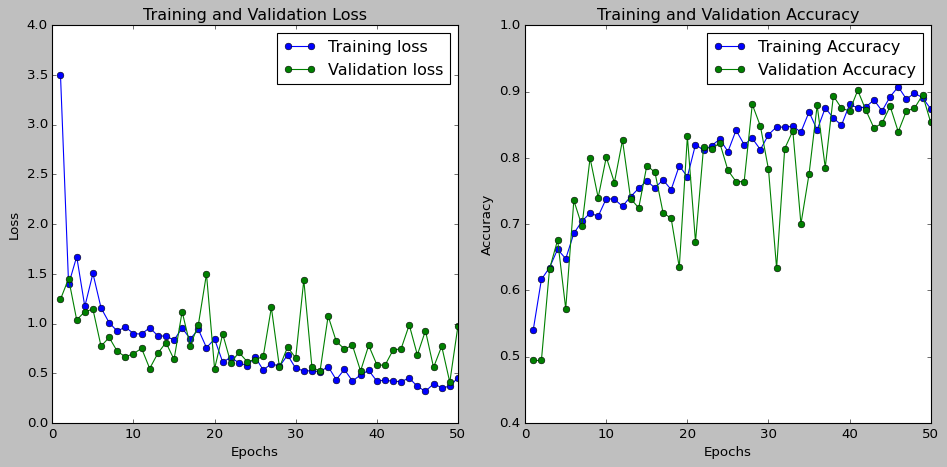

In [68]:
import matplotlib.pyplot as plt


history_dict = history.history


plt.style.use('classic')

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1) 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'o-', label='Training loss')
plt.plot(epochs, val_loss_values, 'o-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)  
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout() 
plt.show()


4/4 [==============================] - 2s 427ms/step


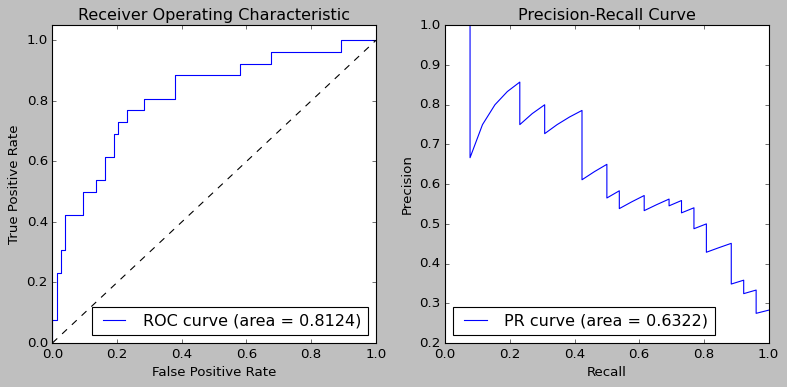

Accuracy: 0.8100
Precision: 0.7333
Recall: 0.4231
F1 Score: 0.5366
Specificity: 0.9459
ROC-AUC: 0.8124
Confusion Matrix: 
[[70  4]
 [15 11]]


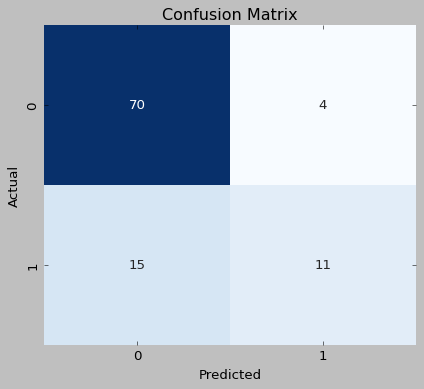

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

predictions = combined_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = test_generator.classes


accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)


tn, fp, fn, tp = confusion_matrix(true_classes, predicted_classes).ravel()
specificity = tn / (tn + fp)


roc_auc = roc_auc_score(true_classes, predictions)


fpr, tpr, _ = roc_curve(true_classes, predictions)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

precision_curve, recall_curve, _ = precision_recall_curve(true_classes, predictions)
pr_auc = auc(recall_curve, precision_curve)
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label='PR curve (area = %0.4f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix: \n{confusion_matrix(true_classes, predicted_classes)}")

cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


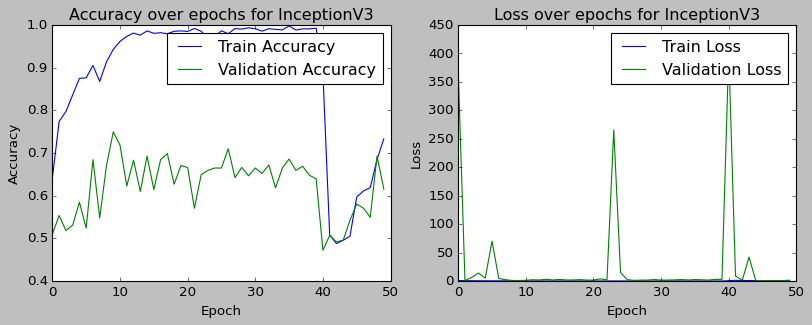

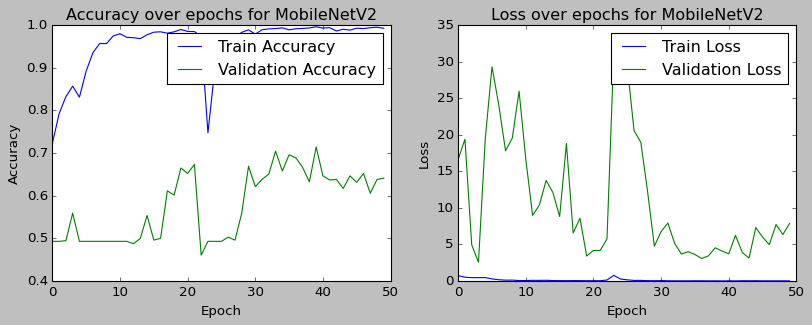

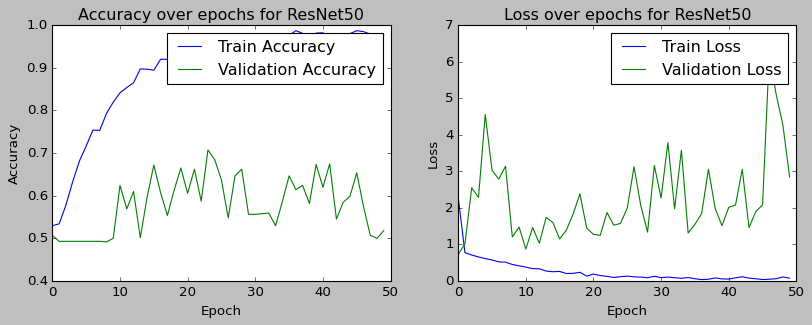

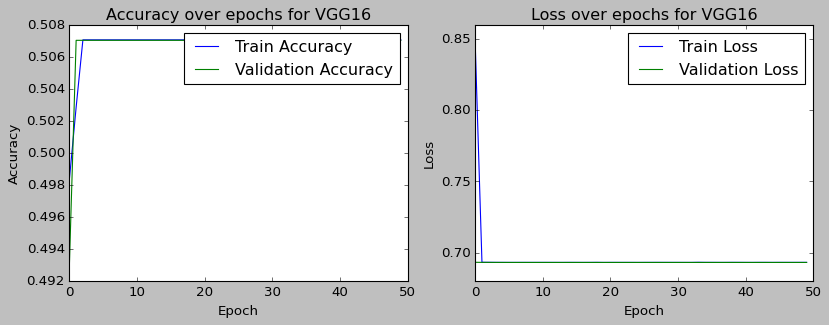

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

base_path = 'D:/MV/CHC6781_Machine_Vision/notebooks/history/'
files = ['InceptionV3_history.csv', 'MobileNetV2_history.csv', 'ResNet50_history.csv', 'VGG16_history.csv']


for file_name in files:

    file_path = base_path + file_name
    

    history = pd.read_csv(file_path)
    

    plt.figure(figsize=(12, 4))
    

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['accuracy'], label='Train Accuracy')
    plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs for ' + file_name.split('_')[0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs for ' + file_name.split('_')[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

    plt.show()
